## 预测糖尿病模型
#### 作者：王媛媛 王丽

### 一、导入所需要模块

In [1]:
import numpy as np    
import pandas as pd
import seaborn as sns    #绘制图形
from pandas import set_option
import matplotlib.pyplot as plt    #可视化软件
plt.style.use('fivethirtyeight')    # 设置绘图风格
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28, 18
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签

In [2]:
from sklearn.metrics import roc_auc_score    #创建决策树分类器
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.model_selection import KFold    #引入交叉验证
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline #自动化处理 
from sklearn.preprocessing import StandardScaler #标准化数据
import timeit    #计算运算时间
from sklearn.metrics import confusion_matrix    #导入混淆矩阵
from sklearn.metrics import accuracy_score #准确率评分

In [3]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB #符合高斯分布的朴素贝叶斯
from sklearn.svm import SVC

### 二、数据处理

### 1.导入数据

In [5]:
diabetes = pd.read_csv(r"F:\kaidian\diabetes.csv",encoding='gbk')    #导入数据，读取CSV数据

#### 数据标签说明
【1】Pregnancies：怀孕次数

【2】Glucose：葡萄糖

【3】BloodPressure：血压 (mm Hg)

【4】SkinThickness：皮层厚度 (mm)

【5】Insulin：胰岛素 2小时血清胰岛素（mu U / ml

【6】BMI：体重指数 （体重/身高）^2

【7】DiabetesPedigreeFunction：糖尿病谱系功能

【8】Age：年龄 （岁）

【9】Outcome：类标变量 （0或1）

### 2.查看数据

In [6]:
diabetes.info()    # 查看数据集的有关信息
print(diabetes.shape)    #数据维度

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
(768, 9)


In [7]:
diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [8]:
set_option('precision',2)    #描述性统计信息
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


### 3.处理缺失值

####  首先把数据分为两类：一类患病，一类不患病，然后，处理缺失值，把患病的缺失值用该类中的平均值代替，把不患病的缺失值用不患病类中的平均值代替。最后把两类合并得出处理后的数据。

In [9]:
diabetes0 = diabetes[diabetes['Outcome'] < 1]    #取结果不患病的数据
diabetes1 =diabetes[diabetes['Outcome'] > 0]
for attribute in diabetes0.columns[1:6]:    #对缺失值进行均值插值处理
    for i in diabetes0.index:
        if diabetes0[attribute][i] == 0:
            diabetes0[attribute][i] = np.mean(diabetes0[attribute])
for attribute in diabetes1.columns[1:6]:
    for i in diabetes1.index:
        if diabetes1[attribute][i] == 0:
            diabetes1[attribute][i] = np.mean(diabetes1[attribute])

In [10]:
diabetes = pd.merge(diabetes0,diabetes1,how = 'outer')    #整合两列数据

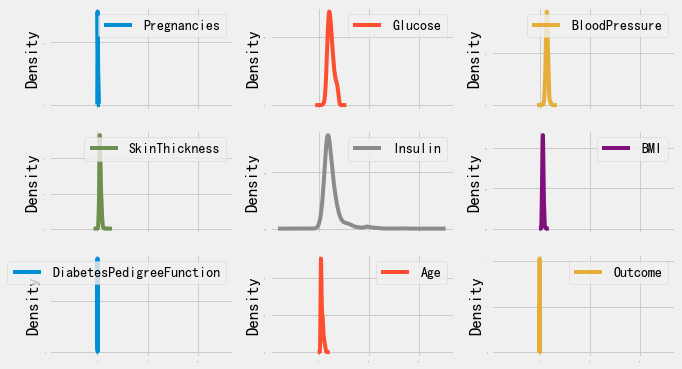

In [11]:
#画出密度图，看每个数据的分布
diabetes.plot(kind='density',subplots=True,layout=(3,3),fontsize=1,figsize=(10,6))
plt.show()

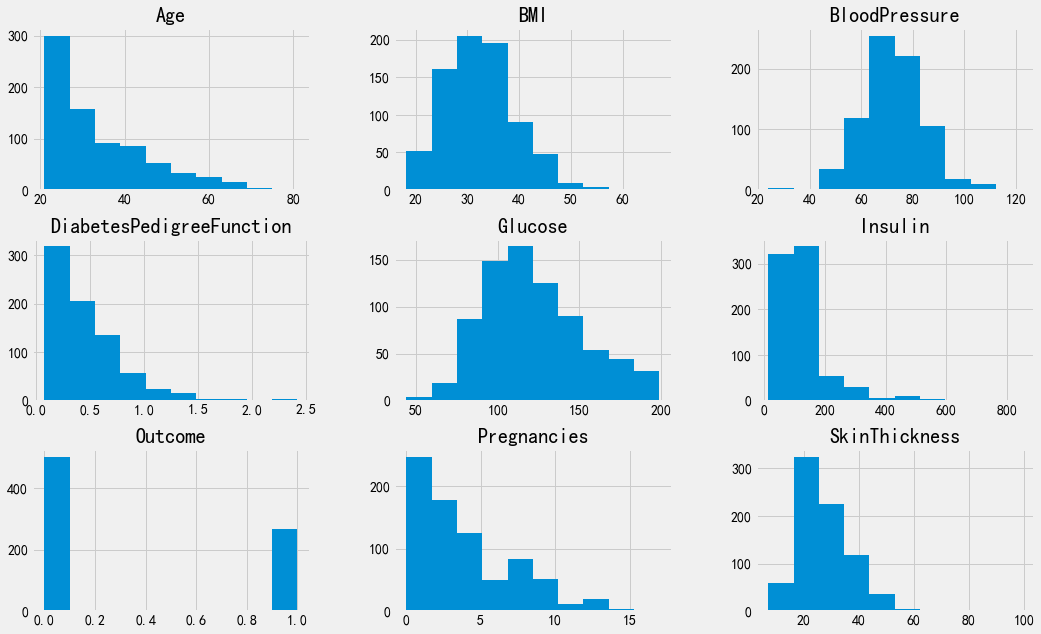

In [12]:
#绘制直方图，大致看出数据分类的平衡程度
diabetes.hist(figsize=(16,10))
plt.show()

### 4.处理异常值

#### 绘制箱线图，可以看出数据存在离群值，进行离群值处理（剔除）。

#### 箱线图异常值定义为小于$Q_1 - 1.5IQR$或大于$Q_3 + 1.5IQR$ $IQR = Q_3 - Q_1$

Pregnancies                     AxesSubplot(0.08,0.641765;0.255882x0.238235)
Glucose                     AxesSubplot(0.387059,0.641765;0.255882x0.238235)
BloodPressure               AxesSubplot(0.694118,0.641765;0.255882x0.238235)
SkinThickness                   AxesSubplot(0.08,0.355882;0.255882x0.238235)
Insulin                     AxesSubplot(0.387059,0.355882;0.255882x0.238235)
BMI                         AxesSubplot(0.694118,0.355882;0.255882x0.238235)
DiabetesPedigreeFunction            AxesSubplot(0.08,0.07;0.255882x0.238235)
Age                             AxesSubplot(0.387059,0.07;0.255882x0.238235)
Outcome                         AxesSubplot(0.694118,0.07;0.255882x0.238235)
dtype: object

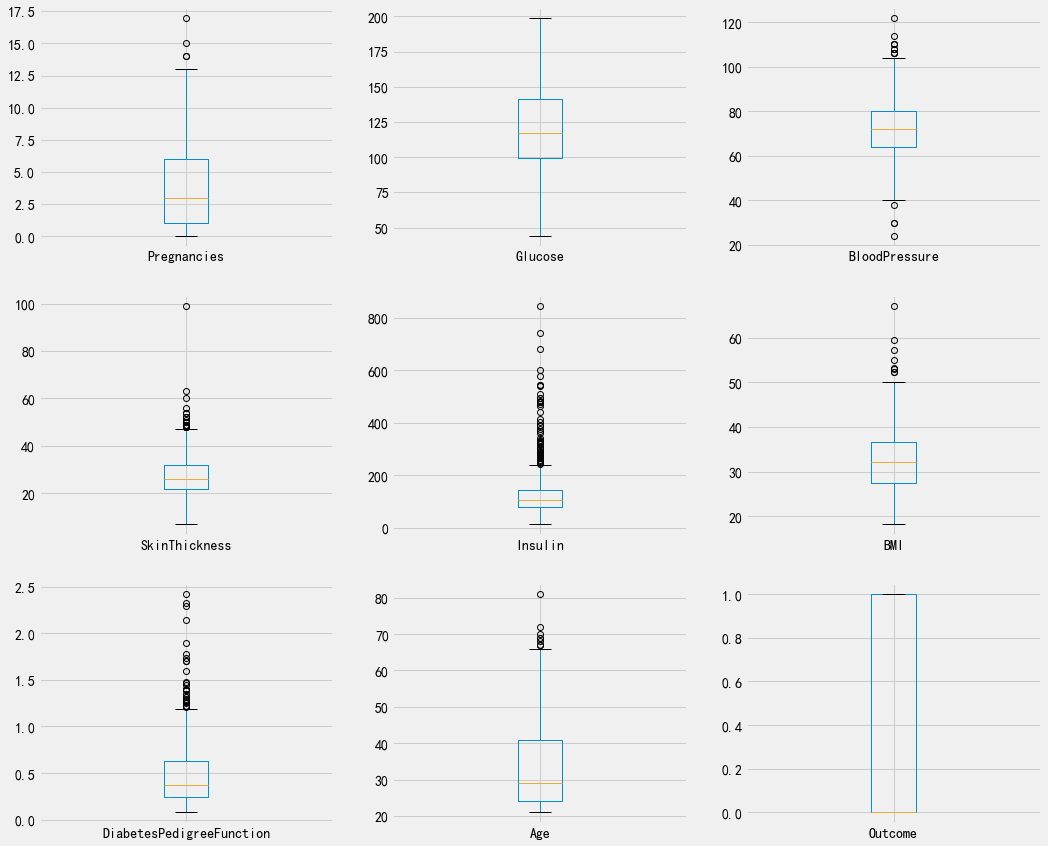

In [13]:
diabetes.plot(kind='box', subplots=True, layout=(3,3), sharex=False,sharey=False, figsize=(16,14))

In [14]:
for attribute in diabetes.columns[1:7]:    #找出离群值，进行剔除
    first_quartile = diabetes[attribute].describe()['25%']    #下四分位数
    third_quartile = diabetes[attribute].describe()['75%']    #上四分位数
    iqr = third_quartile - first_quartile

    diabetes = diabetes[(diabetes[attribute] > (first_quartile - 3 * iqr)) &
           (diabetes[attribute] < (third_quartile + 3 * iqr))]
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,737.00,737.00,737.00,737.00,737.00,737.00,737.00,737.00,737.00
mean,3.89,119.99,72.35,27.09,117.54,32.21,0.46,33.22,0.34
std,3.38,29.55,12.02,8.71,56.74,6.67,0.30,11.73,0.47
min,0.00,44.00,24.00,7.00,15.00,18.20,0.08,21.00,0.00
25%,1.00,99.00,64.00,21.00,80.00,27.40,0.24,24.00,0.00
50%,3.00,115.00,72.00,25.00,104.00,32.00,0.37,29.00,0.00
75%,6.00,138.00,80.00,32.00,140.00,36.30,0.61,41.00,1.00
max,17.00,199.00,122.00,60.00,342.00,57.30,1.73,81.00,1.00


#### 处理后的数据

In [15]:
x = diabetes.iloc[:,:8]    #x为前八列数据
y = diabetes.iloc[:,-1:]

### 二、建立模型

#### 1. 构建多种分类器进行分类
#### 构建了逻辑回归模型、KNN模型、决策树模型、贝叶斯分类模型、和SVM分类模型，对数据进行训练和分类

In [16]:
#划分数据集
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state = 1)  

#### 交叉验证，大概看一下几种模型的预测效果

In [18]:
num_fold = 10    #表示划分为几块（评估算法的基准）
seed = 7    #固定随机起点
scoring = 'accuracy'    #使用准确率为结果的度量指标

#评估算法——处理后的数据
modes = {}    #调用分类函数
modes['LR'] = LogisticRegression()
modes['KNN'] = KNeighborsClassifier()
modes['Tree'] = DecisionTreeClassifier()
modes['NB']  = GaussianNB()
modes['SVM'] = SVC()

results = []
for key in modes:
    kfold = KFold(n_splits=num_fold,random_state=seed)    #交叉验证
    cv_results = cross_val_score(modes[key],x_train,y_train)    # 该函数用交叉检验(cross-validation)来估计一个模型的得分
    results.append(cv_results)
    print('{0}算法{1:.2%},标准方差：{2:2f}'.format(key,cv_results.mean(),cv_results.mean(),cv_results.std()))

LR算法76.89%,标准方差：0.768932
KNN算法84.08%,标准方差：0.840777
Tree算法80.58%,标准方差：0.805825
NB算法76.89%,标准方差：0.768932
SVM算法79.42%,标准方差：0.794175


In [34]:
def function(model,x_train,x_test,y_train,y_test):    #定义训练模型函数
    clf = model
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    mat = confusion_matrix(y_test, y_pred)    #混淆矩阵
    score = model.score(x_train,y_train)    #训练得分
    print(f'训练后的混淆矩阵为：\n{mat}')
    print(f'训练得分为：{score}')
    plt.figure(figsize=(6, 4))
    sns.heatmap(mat, square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()

训练后的混淆矩阵为：
[[133  14]
 [ 31  44]]
训练得分为：0.7883495145631068


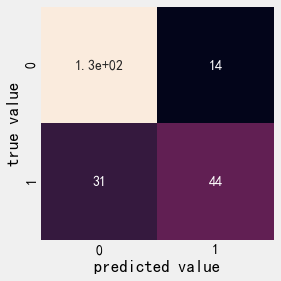

训练后的混淆矩阵为：
[[131  16]
 [ 26  49]]
训练得分为：0.8815533980582524


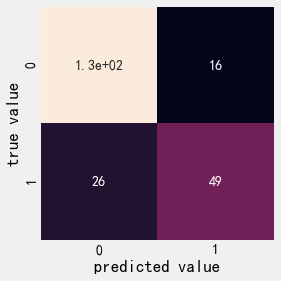

训练后的混淆矩阵为：
[[130  17]
 [ 23  52]]
训练得分为：1.0


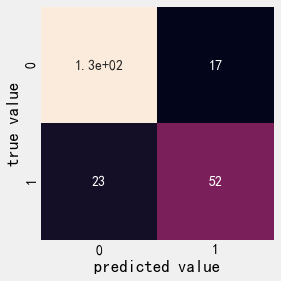

训练后的混淆矩阵为：
[[127  20]
 [ 27  48]]
训练得分为：0.7786407766990291


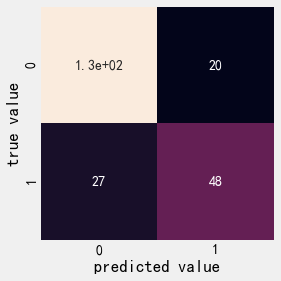

训练后的混淆矩阵为：
[[136  11]
 [ 30  45]]
训练得分为：0.8058252427184466


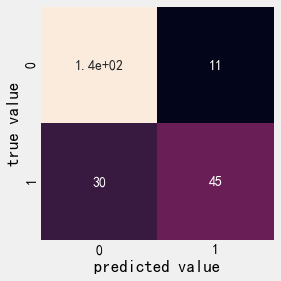

In [35]:
function(modes['LR'],x_train,x_test,y_train,y_test)
function(modes['KNN'],x_train,x_test,y_train,y_test)
function(modes['Tree'],x_train,x_test,y_train,y_test)
function(modes['NB'],x_train,x_test,y_train,y_test)
function(modes['SVM'],x_train,x_test,y_train,y_test)

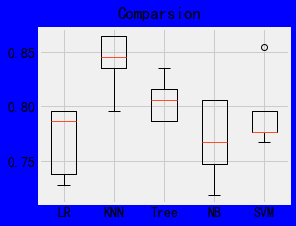

In [21]:
#评估算法——箱线图
fig =plt.figure(figsize=(4, 3), facecolor='blue')
fig.suptitle('Comparsion')    #绘制总标题
ax = fig.add_subplot(111)    #将画布分割成1行1列第一个
plt.boxplot(results)
ax.set_xticklabels(modes.keys())
plt.show()

#### 2.对数据进行标准化处理，再次验证模型分类正确率。

In [22]:
#评估算法——标准化
pipelines = {}
pipelines['ScalerLR'] = Pipeline([('Scaler',StandardScaler()),('LR',LogisticRegression())])
pipelines['ScalerKNN'] = Pipeline([('Scaler',StandardScaler()),('KNN',KNeighborsClassifier())])
pipelines['ScalerTree'] = Pipeline([('Scaler',StandardScaler()),('Tree',DecisionTreeClassifier())])
pipelines['ScalerNB'] = Pipeline([('Scaler',StandardScaler()),('NB',GaussianNB())])
pipelines['ScalerSVM'] = Pipeline([('Scaler',StandardScaler()),('SVM',SVC())])

In [23]:
results = []
for key in pipelines:
    kfold = KFold(n_splits=num_fold,random_state=seed)
    cv_results = cross_val_score(pipelines[key],x_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    print('{0}算法 准确率{1:.2%},标准方差:{2:.2f}'.format(key,cv_results.mean(),cv_results.std()))

ScalerLR算法 准确率78.66%,标准方差:0.06
ScalerKNN算法 准确率79.65%,标准方差:0.06
ScalerTree算法 准确率80.81%,标准方差:0.06
ScalerNB算法 准确率77.50%,标准方差:0.04
ScalerSVM算法 准确率81.96%,标准方差:0.07


### 三、优化模型

#### 1.对决策树进行优化，得出随机森林分类器，并进行调整参数来获取更好的结果

In [24]:
# 随机森林, 通过调整参数来获取更好的结果
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000, 
    max_depth=None, # 定义树的深度, 可以用来防止过拟合
    min_samples_split=10, # 定义至少多少个样本的情况下才继续分叉
    #min_weight_fraction_leaf=0.02 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
# 训练模型
start=timeit.default_timer()    #计算程序运行时间，求得开始时间
rf.fit(x_train, y_train)
# 做预测
y_pred = rf.predict(x_test)
print ("\n\n ---随机森林---")
rf_roc_auc = roc_auc_score(y_test, y_pred)
print ("随机森林 AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, y_pred))
# 模型的准确率
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
end=timeit.default_timer()
timetest_rf=end-start
print(f'程序运行时间: {timetest_rf} Seconds')



 ---随机森林---
随机森林 AUC = 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       147
           1       0.86      0.73      0.79        75

    accuracy                           0.87       222
   macro avg       0.87      0.84      0.85       222
weighted avg       0.87      0.87      0.87       222

Accuracy: 0.8693693693693694
程序运行时间: 2.380926600000066 Seconds


#### 2.对KNN算法进行优化，进行调整参数来获取更好的结果。

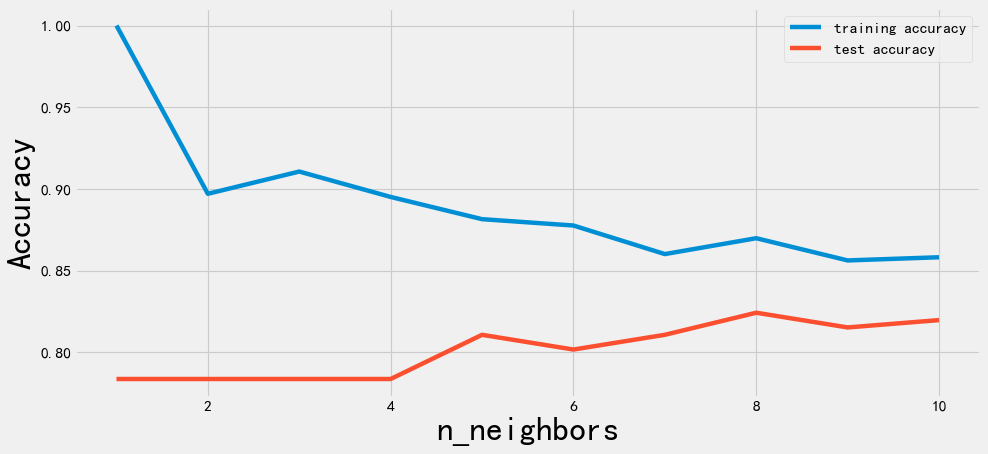

In [25]:
training_accuracy=[]
test_accuracy=[]

neighbors_settings=range(1,11)    #尝试k=1到11
start=timeit.default_timer()    #计算程序运行时间，求得开始时间
for n_neighbors in neighbors_settings:

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train,y_train)
    training_accuracy.append(knn.score(x_train,y_train))

    test_accuracy.append(knn.score(x_test,y_test))
plt.figure(figsize=(13,6),dpi=80)
plt.plot(neighbors_settings,training_accuracy,label="training accuracy")
plt.plot(neighbors_settings,test_accuracy,label="test accuracy")
plt.ylabel("Accuracy",size=30)
plt.xlabel("n_neighbors",size=30)
plt.legend()
plt.savefig('knn_compare_model')

In [26]:
#可以看出来k=5时，测试准确性最高，所以选k=5
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
 
print(f'Accuracy of K-NN classifier on training set:{knn.score(x_train,y_train):.2f}')
print(f'Accuracy of K-NN classifier on test set:{knn.score(x_test,y_test):.2f}')
end=timeit.default_timer()
timetest_rf=end-start
print(f'程序运行时间: {timetest_rf} Seconds')

Accuracy of K-NN classifier on training set:0.88
Accuracy of K-NN classifier on test set:0.81
程序运行时间: 3.133899700000029 Seconds


#### 3.对SVM算法进行优化，进行调整参数来获取更好的结果。

In [32]:
#支持向量机调参（C惩罚系数，Kernel内核函数）
from sklearn.model_selection import GridSearchCV    #网格搜索
scaler = StandardScaler().fit(x_train)
rescalerX = scaler.transform(x_train).astype(float)
param_grid = {}
param_grid['C'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.3,1.5,1.7,2.0]
param_grid['kernel'] = ['linear','poly','rbf','sigmoid']
start=timeit.default_timer()    #计算程序运行时间，求得开始时间 
model = SVC()

kfold = KFold(n_splits=num_fold,random_state=seed)
grid_result = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scoring,cv=KFold)
grid_result = GridSearchCV(model,param_grid)
grid_result.fit(x_train,y_train)

kfold = KFold(n_splits=num_fold,random_state=seed)
print('最好模型准确率为:{0:.2%},参数是:{1}'.format(grid_result.best_score_,grid_result.best_params_))

cv_results = zip(grid_result.cv_results_['mean_test_score'],
grid_result.cv_results_['std_test_score'],
grid_result.cv_results_['params'])
end=timeit.default_timer()
timetest_rf=end-start
print(f'程序运行时间: {timetest_rf} Seconds')
for mean,std,param in cv_results:
    print('算法准确率：{0:.2%},标准方差：{1:.2f}，参数{2}'.format(mean,std,param))

最好模型准确率为:81.94%,参数是:{'C': 2.0, 'kernel': 'rbf'}
程序运行时间: 34.716963299999975 Seconds
算法准确率：75.92%,标准方差：0.03，参数{'C': 0.1, 'kernel': 'linear'}
算法准确率：78.83%,标准方差：0.03，参数{'C': 0.1, 'kernel': 'poly'}
算法准确率：75.92%,标准方差：0.03，参数{'C': 0.1, 'kernel': 'rbf'}
算法准确率：66.41%,标准方差：0.00，参数{'C': 0.1, 'kernel': 'sigmoid'}
算法准确率：76.70%,标准方差：0.02，参数{'C': 0.2, 'kernel': 'linear'}
算法准确率：78.83%,标准方差：0.03，参数{'C': 0.2, 'kernel': 'poly'}
算法准确率：78.45%,标准方差：0.03，参数{'C': 0.2, 'kernel': 'rbf'}
算法准确率：62.91%,标准方差：0.01，参数{'C': 0.2, 'kernel': 'sigmoid'}
算法准确率：76.70%,标准方差：0.02，参数{'C': 0.3, 'kernel': 'linear'}
算法准确率：78.64%,标准方差：0.03，参数{'C': 0.3, 'kernel': 'poly'}
算法准确率：79.03%,标准方差：0.04，参数{'C': 0.3, 'kernel': 'rbf'}
算法准确率：54.37%,标准方差：0.03，参数{'C': 0.3, 'kernel': 'sigmoid'}
算法准确率：77.09%,标准方差：0.01，参数{'C': 0.4, 'kernel': 'linear'}
算法准确率：79.22%,标准方差：0.01，参数{'C': 0.4, 'kernel': 'poly'}
算法准确率：78.45%,标准方差：0.04，参数{'C': 0.4, 'kernel': 'rbf'}
算法准确率：50.29%,标准方差：0.03，参数{'C': 0.4, 'kernel': 'sigmoid'}
算法准确率：76.89%,标准方差：0.02，参数{'C': 0.5, '

### 四、确定最终模型

#### 根据算法的准确率，最终最高准确率的是随机森林分类器。

In [33]:
#确定最终模型
scaler = StandardScaler().fit(x_train)
rescalerX = scaler.transform(x_train)
start=timeit.default_timer()    #计算程序运行时间，求得开始时间
y_pred = rf.predict(x_test)
print ("\n\n ---随机森林---")
rf_roc_auc = roc_auc_score(y_test, y_pred)
print ("随机森林 AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, y_pred))

# 模型的准确率
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
end=timeit.default_timer()
timetest_rf=end-start
print(f'程序运行时间: {timetest_rf} Seconds')



 ---随机森林---
随机森林 AUC = 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       147
           1       0.86      0.73      0.79        75

    accuracy                           0.87       222
   macro avg       0.87      0.84      0.85       222
weighted avg       0.87      0.87      0.87       222

Accuracy: 0.8693693693693694
程序运行时间: 0.16823870000007446 Seconds
